In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import math
import warnings
from copy import deepcopy
from typing import Dict, List, Optional, Tuple, Union

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch import Tensor

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split

from wavelets_pytorch.wavelets import Morlet, Paul
from wavelets_pytorch.transform import WaveletTransformTorch

from sklearn.decomposition import PCA

import librosa
import torchaudio

import matplotlib_inline
import matplotlib.pyplot as plt

from IPython.display import display, Audio, Markdown

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [3]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Data stuff

In [4]:
class EEGDataset(Dataset):
    def __init__(self, path: str, audio_maps: dict, fragment_length: int = 2012,
                 partition_size: int = 32, sample_rate: int = 44100, sound_channel: int = 1,
                 preloaded_audios: bool = False, val_ratio: float = 0.15):
        '''
        path: path to sections (folders)
        audio_maps: two-level map: section names -> labels -> audio_paths
        fragment_lengtht: length of fragment after label
        partition_size: number of nonzero labels in each csv file
        sample_rate: audios' SR
        sound_channel: mono audio channel
        preloaded_audios: if audio_maps lead to paths (False) or directly to data like raw signal or FT (True)
        val_ratio: float in range [0, 1], N_val / N
        '''
        super().__init__()
        self.sections = sorted(os.listdir(path))
        assert set(self.sections) == set(audio_maps.keys()), "Sections must be the same!"
        self.audio_maps = audio_maps 
        self.preloaded_audios = preloaded_audios
        
        all_paths = [[os.path.join(path, sec, file) for file in sorted(os.listdir(os.path.join(path, sec)))] for sec in self.sections]
        num_all_files = [len(elem) for elem in all_paths]
        splits = [int(elem * val_ratio) for elem in num_all_files]
        
        self.val_paths = [sec_paths[:split] for sec_paths, split in zip(all_paths, splits)]
        self.paths = [sec_paths[split:] for sec_paths, split in zip(all_paths, splits)]
        
        self.sec_num_files = [len(elem) for elem in self.paths]
        self.sec_cumnum = np.cumsum(self.sec_num_files) * partition_size
        self.total_num_files = sum(self.sec_num_files)
        
        self.sec_num_val_files = [len(elem) for elem in self.val_paths]
        self.sec_val_cumnum = np.cumsum(self.sec_num_val_files) * partition_size
        self.total_num_val_files = sum(self.sec_num_val_files)
        
        self.partition_size = partition_size
        self.fragment_length = fragment_length
        self.sr = sample_rate
        self.sound_channel = sound_channel
        self.val_mode = False
        
    def __len__(self) -> int:
        num = self.total_num_val_files if self.val_mode else self.total_num_files
        return num * self.partition_size
    
    def set_val_mode(self, mode: bool):
        '''
        Switch between train/val subsets
        mode: 0 -> train, 1 -> val
        '''
        assert mode in [True, False], "Incorrect mode type!"
        self.val_mode = mode
        return self
    
    def to_section(self, idx: int) -> Tuple[int, int]:
        '''
        Get file section and inner index by its absolute index
        idx: absolute index
        return inner index, section number (idx)
        '''
        cumnum = self.sec_val_cumnum if self.val_mode else self.sec_cumnum
        section = np.where(idx < cumnum)[0][0]
        section_idx = idx if (section == 0) else (idx - cumnum[section - 1])
        return section, section_idx
    
    def get_audio(self, section: str, label: int) -> torch.Tensor:
        '''
        Get audio by section and corresponding label
        section: number of section
        label: one of label values in given section
        return: the audio
        '''
        section_name = self.sections[section]
        
        if self.preloaded_audios:
            return self.audio_maps[section_name][label]
        
        audio, current_sr = torchaudio.load(self.audio_maps[section_name][label])
        audio = torchaudio.functional.resample(audio, orig_freq=current_sr, new_freq=self.sr)
        return audio[self.sound_channel]
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        '''
        int idx: file ID
        return: EEG fragment with its corresponding audio
        '''
        section, section_idx = self.to_section(idx)
        paths_source = self.val_paths if self.val_mode else self.paths
        file_path = paths_source[section][section_idx // self.partition_size]
        
        start = (section_idx % self.partition_size) * self.fragment_length
        end = start + self.fragment_length
        
        data = pd.read_feather(file_path).to_numpy()
        x, label = torch.tensor(data[start:end, 1:]), data[start, 0].astype(int)
        
        audio = self.get_audio(section, label)
        
        return x, audio

In [5]:
base = os.path.join(".", "Data", "Vartanov", "audios")

A = "A.wav"
B = "B.wav"
F = "F.wav"
G = "G.wav"
M = "M.wav"
R = "R.wav"
U = "U.wav"

Ba = "Ba.wav"
Bu = "Bu.wav"
Fa = "Fa.wav"
Fu = "Fu.wav"
Ga = "Ga.wav"
Gu = "Gu.wav"
Ma = "Ma.wav"
Mu = "Mu.wav"
Ra = "Ra.wav"
Ru = "Ru.wav"

Biblioteka = "St1.wav"
Raketa = "St2.wav"
Kurier = "St3.wav"
Ograda = "St4.wav"
Haketa = "St5.wav"

phonemes_m3_labels = {
    12: os.path.join(base, "phonemes", A),
    22: os.path.join(base, "phonemes", A),
    13: os.path.join(base, "phonemes", B),
    23: os.path.join(base, "phonemes", B),
    14: os.path.join(base, "phonemes", F),
    24: os.path.join(base, "phonemes", F),
    15: os.path.join(base, "phonemes", G),
    25: os.path.join(base, "phonemes", G),
    16: os.path.join(base, "phonemes", M),
    26: os.path.join(base, "phonemes", M),
    17: os.path.join(base, "phonemes", R),
    27: os.path.join(base, "phonemes", R),
    18: os.path.join(base, "phonemes", U),
    28: os.path.join(base, "phonemes", U)
}

phonemes_m4_labels = {
    1: os.path.join(base, "phonemes", A),
    11: os.path.join(base, "phonemes", A),
    2: os.path.join(base, "phonemes", B),
    12: os.path.join(base, "phonemes", B),
    3: os.path.join(base, "phonemes", F),
    13: os.path.join(base, "phonemes", F),
    4: os.path.join(base, "phonemes", G),
    14: os.path.join(base, "phonemes", G),
    5: os.path.join(base, "phonemes", M),
    15: os.path.join(base, "phonemes", M),
    6: os.path.join(base, "phonemes", R),
    16: os.path.join(base, "phonemes", R),
    7: os.path.join(base, "phonemes", U),
    17: os.path.join(base, "phonemes", U)
}

syllables_labels = {
    1: os.path.join(base, "syllables", Ba),
    11: os.path.join(base, "syllables", Ba),
    2: os.path.join(base, "syllables", Fa),
    12: os.path.join(base, "syllables", Fa),
    3: os.path.join(base, "syllables", Ga),
    13: os.path.join(base, "syllables", Ga),
    4: os.path.join(base, "syllables", Ma),
    14: os.path.join(base, "syllables", Ma),
    5: os.path.join(base, "syllables", Ra),
    15: os.path.join(base, "syllables", Ra),
    6: os.path.join(base, "syllables", Bu),
    16: os.path.join(base, "syllables", Bu),
    7: os.path.join(base, "syllables", Ru),
    17: os.path.join(base, "syllables", Ru),
    8: os.path.join(base, "syllables", Mu),
    18: os.path.join(base, "syllables", Mu),
    9: os.path.join(base, "syllables", Fu),
    19: os.path.join(base, "syllables", Fu),
    10: os.path.join(base, "syllables", Gu),
    20: os.path.join(base, "syllables", Gu)
}

words_labels = {
    11: os.path.join(base, "words", Biblioteka),
    21: os.path.join(base, "words", Biblioteka),
    12: os.path.join(base, "words", Raketa),
    22: os.path.join(base, "words", Raketa),
    13: os.path.join(base, "words", Kurier),
    23: os.path.join(base, "words", Kurier),
    14: os.path.join(base, "words", Ograda),
    24: os.path.join(base, "words", Ograda),
    15: os.path.join(base, "words", Haketa),
    25: os.path.join(base, "words", Haketa)
}

raw_audio_map = {
    "syllables": syllables_labels,
    "phonemes_m3": phonemes_m3_labels,
    "phonemes_m4": phonemes_m4_labels,
    "words": words_labels
}

In [6]:
unique_paths = []
for sec in raw_audio_map:
    for label in raw_audio_map[sec]:
        path = raw_audio_map[sec][label]
        if path not in unique_paths:
            unique_paths.append(path)
unique_paths

['.\\Data\\Vartanov\\audios\\syllables\\Ba.wav',
 '.\\Data\\Vartanov\\audios\\syllables\\Fa.wav',
 '.\\Data\\Vartanov\\audios\\syllables\\Ga.wav',
 '.\\Data\\Vartanov\\audios\\syllables\\Ma.wav',
 '.\\Data\\Vartanov\\audios\\syllables\\Ra.wav',
 '.\\Data\\Vartanov\\audios\\syllables\\Bu.wav',
 '.\\Data\\Vartanov\\audios\\syllables\\Ru.wav',
 '.\\Data\\Vartanov\\audios\\syllables\\Mu.wav',
 '.\\Data\\Vartanov\\audios\\syllables\\Fu.wav',
 '.\\Data\\Vartanov\\audios\\syllables\\Gu.wav',
 '.\\Data\\Vartanov\\audios\\phonemes\\A.wav',
 '.\\Data\\Vartanov\\audios\\phonemes\\B.wav',
 '.\\Data\\Vartanov\\audios\\phonemes\\F.wav',
 '.\\Data\\Vartanov\\audios\\phonemes\\G.wav',
 '.\\Data\\Vartanov\\audios\\phonemes\\M.wav',
 '.\\Data\\Vartanov\\audios\\phonemes\\R.wav',
 '.\\Data\\Vartanov\\audios\\phonemes\\U.wav',
 '.\\Data\\Vartanov\\audios\\words\\St1.wav',
 '.\\Data\\Vartanov\\audios\\words\\St2.wav',
 '.\\Data\\Vartanov\\audios\\words\\St3.wav',
 '.\\Data\\Vartanov\\audios\\words\\St4.wav

Calculate STFT+PCAs to avoid additional train loop calculations:

In [7]:
max_audio_length = 201776
n_components = 512
SR = 44100
n_fft = 2048
hop_size = 512
sound_channel = 1

In [8]:
audios_ = [torchaudio.load(path) for path in unique_paths]

joined_audios = []
for x, sr_ in audios_:
    if sr_ != SR:
        x = torchaudio.functional.resample(waveform=x, orig_freq=sr_, new_freq=SR)[sound_channel]
    joined_audios.append(x)

joined_audios = torch.cat(joined_audios)
joined_audios = torch.stft(joined_audios, n_fft=n_fft, hop_length=hop_size, return_complex=True)
joined_audios = torch.abs(joined_audios).t().numpy()
joined_audios.shape

(1614, 1025)

In [9]:
pca = PCA(n_components=n_components)
pca.fit(joined_audios)

PCA(n_components=512)

In [10]:
stft_audio_map = deepcopy(raw_audio_map)
for sec in stft_audio_map:
    for label in stft_audio_map[sec]:
        audio_path = stft_audio_map[sec][label]
        x, sr_ = torchaudio.load(stft_audio_map[sec][label])
        x = torchaudio.functional.resample(x, orig_freq=sr_, new_freq=SR)[sound_channel]
        assert max_audio_length - len(x) >= 0, "!?"
        x = torch.cat([x, torch.zeros(max_audio_length - len(x))]) # for no-decoder mode only
        x = torch.stft(x, n_fft=n_fft, hop_length=hop_size, return_complex=True)
        x = torch.abs(x).T
        x = x - pca.mean_
        x = x @ pca.components_.T
        stft_audio_map[sec][label] = x.T

In [11]:
val_ratio = 0.15

dataset_ = EEGDataset(
    os.path.join(".", "Data", "Vartanov", "feather"),
    raw_audio_map,
    preloaded_audios=False,
    sound_channel=sound_channel
)

train_dataset = EEGDataset(
    os.path.join(".", "Data", "Vartanov", "feather"),
    stft_audio_map,
    preloaded_audios=True,
    sound_channel=sound_channel,
    val_ratio=val_ratio
)

val_dataset = EEGDataset(
    os.path.join(".", "Data", "Vartanov", "feather"),
    stft_audio_map,
    preloaded_audios=True,
    sound_channel=sound_channel,
    val_ratio=val_ratio
).set_val_mode(True)

In [12]:
x, audio = dataset_[0]
Audio(audio, rate=dataset_.sr)

In [13]:
x, spec = train_dataset[0]
x.shape, spec.shape

(torch.Size([2012, 63]), torch.Size([512, 395]))

In [14]:
x, spec = val_dataset[0]
x.shape, spec.shape

(torch.Size([2012, 63]), torch.Size([512, 395]))

# Wavelet

In [15]:
dj = 0.8
eeg_sr = 1006.24

In [16]:
x = x.T.to(device).to(torch.float) # -> (63, ...)
x = x.unsqueeze(0)
x.shape

torch.Size([1, 63, 2012])

In [17]:
assert torch.cuda.is_available(), "!?"
wvt_transformer = WaveletTransformTorch(
    dt=eeg_sr,
    dj=dj,
    cuda=True
)

In [18]:
wvt_transformer.cwt(x[:, 0, :]).shape

torch.Size([1, 13, 2012])

# Dataloader (w/o aug, noise will be added in a loop)

In [19]:
batch_size = 4

In [20]:
train_dl = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dl = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=0)

In [21]:
next(iter(train_dl))[0].shape, next(iter(train_dl))[1].shape

(torch.Size([4, 2012, 63]), torch.Size([4, 512, 395]))

# Activations

In [22]:
class Swish(nn.Module):
    """
    Swish is a smooth, non-monotonic function that consistently matches or outperforms ReLU on deep networks applied
    to a variety of challenging domains such as Image classification and Machine translation.
    """
    def __init__(self):
        super(Swish, self).__init__()
    
    def forward(self, inputs: Tensor) -> Tensor:
        return inputs * inputs.sigmoid()

In [23]:
class GLU(nn.Module):
    """
    The gating mechanism is called Gated Linear Units (GLU), which was first introduced for natural language processing
    in the paper “Language Modeling with Gated Convolutional Networks”
    """
    def __init__(self, dim: int) -> None:
        super(GLU, self).__init__()
        self.dim = dim

    def forward(self, inputs: Tensor) -> Tensor:
        outputs, gate = inputs.chunk(2, dim=self.dim)
        return outputs * gate.sigmoid()

# Channel reduction / channel encoder

We want (batch_size, seq_len, ???) -> (batch_size, seq_len, d_model)

In [24]:
class ChannelEncoder(nn.Module):
    """
    Encodes a group of channels to an abstract inner representation
    in some space of a given dimension d_model. Doesn't affect sequence length.
    """
    def __init__(self, n_channels: int = 63, d_model: int = 512, dropout_p: float = 0.1) -> None:
        super(ChannelEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.LayerNorm(n_channels),
            nn.Linear(n_channels, d_model),
            nn.ReLU(),
            nn.Linear(d_model, d_model),
            nn.Dropout(p=dropout_p)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Input shape: (batch, seq_length, in_channels)
        Tensor containing input vector

        Return shape: (batch, d_model, seq_length)
        Tensor containing encoded representations.
        """
        assert len(x.shape) == 3, "!?"
        x = self.encoder(x) # (batch, seq_length, d_model)
        return x

# Positional encoding

NOTE: no input and output tensor in this implementation.

In [25]:
class PositionalEncoding(nn.Module):
    """
    Positional Encoding proposed in "Attention Is All You Need".
    Since transformer contains no recurrence and no convolution, in order for the model to make
    use of the order of the sequence, we must add some positional information.

    "Attention Is All You Need" use sine and cosine functions of different frequencies:
        PE_(pos, 2i)    =  sin(pos / power(10000, 2i / d_model))
        PE_(pos, 2i+1)  =  cos(pos / power(10000, 2i / d_model))
    """
    def __init__(self, d_model: int = 512, max_len: int = 10000) -> None:
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model, requires_grad=False)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, length: int) -> Tensor:
        return self.pe[:, :length]

# Conv

In [26]:
class DepthwiseConv1d(nn.Module):
    """
    When groups == in_channels and out_channels == K * in_channels, where K is a positive integer,
    this operation is termed in literature as depthwise convolution.

    Args:
        in_channels (int): Number of channels in the input
        out_channels (int): Number of channels produced by the convolution
        kernel_size (int or tuple): Size of the convolving kernel
        stride (int, optional): Stride of the convolution. Default: 1
        padding (int or tuple, optional): Zero-padding added to both sides of the input. Default: 0
        bias (bool, optional): If True, adds a learnable bias to the output. Default: True

    Inputs: inputs
        - **inputs** (batch, in_channels, time): Tensor containing input vector

    Returns: outputs
        - **outputs** (batch, out_channels, time): Tensor produces by depthwise 1-D convolution.
    """
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            kernel_size: int,
            stride: int = 1,
            padding: int = 0,
            bias: bool = False,
    ) -> None:
        super(DepthwiseConv1d, self).__init__()
        assert out_channels % in_channels == 0, "out_channels should be constant multiple of in_channels"
        self.conv = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            groups=in_channels,
            stride=stride,
            padding=padding,
            bias=bias,
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.conv(inputs)

In [27]:
class PointwiseConv1d(nn.Module):
    """
    When kernel size == 1 conv1d, this operation is termed in literature as pointwise convolution.
    This operation often used to match dimensions.

    Args:
        in_channels (int): Number of channels in the input
        out_channels (int): Number of channels produced by the convolution
        stride (int, optional): Stride of the convolution. Default: 1
        padding (int or tuple, optional): Zero-padding added to both sides of the input. Default: 0
        bias (bool, optional): If True, adds a learnable bias to the output. Default: True

    Inputs: inputs
        - **inputs** (batch, in_channels, time): Tensor containing input vector

    Returns: outputs
        - **outputs** (batch, out_channels, time): Tensor produces by pointwise 1-D convolution.
    """
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            stride: int = 1,
            padding: int = 0,
            bias: bool = True,
    ) -> None:
        super(PointwiseConv1d, self).__init__()
        self.conv = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
            stride=stride,
            padding=padding,
            bias=bias,
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.conv(inputs)

In [28]:
class ConformerConvModule(nn.Module):
    """
    Conformer convolution module starts with a pointwise convolution and a gated linear unit (GLU).
    This is followed by a single 1-D depthwise convolution layer. Batchnorm is  deployed just after the convolution
    to aid training deep models.

    Args:
        in_channels (int): Number of channels in the input
        kernel_size (int or tuple, optional): Size of the convolving kernel Default: 31
        dropout_p (float, optional): probability of dropout

    Inputs: inputs
        inputs (batch, time, dim): Tensor contains input sequences

    Outputs: outputs
        outputs (batch, time, dim): Tensor produces by conformer convolution module.
    """
    def __init__(
            self,
            in_channels: int,
            kernel_size: int = 31,
            expansion_factor: int = 2,
            dropout_p: float = 0.1,
    ) -> None:
        super(ConformerConvModule, self).__init__()
        assert (kernel_size - 1) % 2 == 0, "kernel_size should be a odd number for 'SAME' padding"
        assert expansion_factor == 2, "Currently, Only Supports expansion_factor 2"

        self.sequential = nn.Sequential(
            nn.LayerNorm(in_channels),
            Transpose(shape=(1, 2)),
            PointwiseConv1d(in_channels, in_channels * expansion_factor, stride=1, padding=0, bias=True),
            GLU(dim=1),
            DepthwiseConv1d(in_channels, in_channels, kernel_size, stride=1, padding=(kernel_size - 1) // 2),
            nn.BatchNorm1d(in_channels),
            Swish(),
            PointwiseConv1d(in_channels, in_channels, stride=1, padding=0, bias=True),
            nn.Dropout(p=dropout_p),
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.sequential(inputs).transpose(1, 2)

In [29]:
class Conv2dSubampling(nn.Module):
    """
    Convolutional 2D subsampling (to 1/4 length)

    Args:
        in_channels (int): Number of channels in the input image
        out_channels (int): Number of channels produced by the convolution

    Inputs: inputs
        - **inputs** (batch, time, dim): Tensor containing sequence of inputs

    Returns: outputs
        - **outputs** (batch, time, dim): Tensor produced by the convolution
    """
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super(Conv2dSubampling, self).__init__()
        self.sequential = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2),
            nn.ReLU(),
        )

    def forward(self, inputs: Tensor) -> Tensor:
        outputs = self.sequential(inputs.unsqueeze(1))
        batch_size, channels, subsampled_lengths, sumsampled_dim = outputs.size()
        outputs = outputs.permute(0, 2, 1, 3)
        outputs = outputs.contiguous().view(batch_size, subsampled_lengths, channels * sumsampled_dim)

        return outputs

# Attention

In [30]:
class RelativeMultiHeadAttention(nn.Module):
    """
    Multi-head attention with relative positional encoding.
    This concept was proposed in the "Transformer-XL: Attentive Language Models Beyond a Fixed-Length Context"

    Args:
        d_model (int): The dimension of model
        num_heads (int): The number of attention heads.
        dropout_p (float): probability of dropout

    Inputs: query, key, value, pos_embedding, mask
        - **query** (batch, time, dim): Tensor containing query vector
        - **key** (batch, time, dim): Tensor containing key vector
        - **value** (batch, time, dim): Tensor containing value vector
        - **pos_embedding** (batch, time, dim): Positional embedding tensor
        - **mask** (batch, 1, time2) or (batch, time1, time2): Tensor containing indices to be masked

    Returns:
        - **outputs**: Tensor produces by relative multi head attention module.
    """
    def __init__(
            self,
            d_model: int = 512,
            num_heads: int = 16,
            dropout_p: float = 0.1,
    ):
        super(RelativeMultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model % num_heads should be zero."
        self.d_model = d_model
        self.d_head = int(d_model / num_heads)
        self.num_heads = num_heads
        self.sqrt_dim = math.sqrt(d_model)

        self.query_proj = ConformerLinear(d_model, d_model)
        self.key_proj = ConformerLinear(d_model, d_model)
        self.value_proj = ConformerLinear(d_model, d_model)
        self.pos_proj = ConformerLinear(d_model, d_model, bias=False)

        self.dropout = nn.Dropout(p=dropout_p)
        self.u_bias = nn.Parameter(torch.Tensor(self.num_heads, self.d_head))
        self.v_bias = nn.Parameter(torch.Tensor(self.num_heads, self.d_head))
        torch.nn.init.xavier_uniform_(self.u_bias)
        torch.nn.init.xavier_uniform_(self.v_bias)

        self.out_proj = ConformerLinear(d_model, d_model)

    def forward(
            self,
            query: Tensor,
            key: Tensor,
            value: Tensor,
            pos_embedding: Tensor,
            mask: Optional[Tensor] = None,
    ) -> Tensor:
        batch_size = value.size(0)

        query = self.query_proj(query).view(batch_size, -1, self.num_heads, self.d_head)
        key = self.key_proj(key).view(batch_size, -1, self.num_heads, self.d_head).permute(0, 2, 1, 3)
        value = self.value_proj(value).view(batch_size, -1, self.num_heads, self.d_head).permute(0, 2, 1, 3)
        pos_embedding = self.pos_proj(pos_embedding).view(batch_size, -1, self.num_heads, self.d_head)

        content_score = torch.matmul((query + self.u_bias).transpose(1, 2), key.transpose(2, 3))
        pos_score = torch.matmul((query + self.v_bias).transpose(1, 2), pos_embedding.permute(0, 2, 3, 1))
        pos_score = self._relative_shift(pos_score)

        score = (content_score + pos_score) / self.sqrt_dim

        if mask is not None:
            mask = mask.unsqueeze(1)
            score.masked_fill_(mask, -1e9)

        attn = nn.functional.softmax(score, -1)
        attn = self.dropout(attn)

        context = torch.matmul(attn, value).transpose(1, 2)
        context = context.contiguous().view(batch_size, -1, self.d_model)

        return self.out_proj(context)

    def _relative_shift(self, pos_score: Tensor) -> Tensor:
        batch_size, num_heads, seq_length1, seq_length2 = pos_score.size()
        zeros = pos_score.new_zeros(batch_size, num_heads, seq_length1, 1)
        padded_pos_score = torch.cat([zeros, pos_score], dim=-1)

        padded_pos_score = padded_pos_score.view(batch_size, num_heads, seq_length2 + 1, seq_length1)
        pos_score = padded_pos_score[:, :, 1:].view_as(pos_score)

        return pos_score

In [31]:
class MultiHeadedSelfAttentionModule(nn.Module):
    """
    Conformer employ multi-headed self-attention (MHSA) while integrating an important technique from Transformer-XL,
    the relative sinusoidal positional encoding scheme. The relative positional encoding allows the self-attention
    module to generalize better on different input length and the resulting encoder is more robust to the variance of
    the utterance length. Conformer use prenorm residual units with dropout which helps training
    and regularizing deeper models.

    Args:
        d_model (int): The dimension of model
        num_heads (int): The number of attention heads.
        dropout_p (float): probability of dropout

    Inputs: inputs, mask
        - **inputs** (batch, time, dim): Tensor containing input vector
        - **mask** (batch, 1, time2) or (batch, time1, time2): Tensor containing indices to be masked

    Returns:
        - **outputs** (batch, time, dim): Tensor produces by relative multi headed self attention module.
    """
    def __init__(self, d_model: int, num_heads: int, dropout_p: float = 0.1):
        super(MultiHeadedSelfAttentionModule, self).__init__()
        self.positional_encoding = PositionalEncoding(d_model)
        self.layer_norm = nn.LayerNorm(d_model)
        self.attention = RelativeMultiHeadAttention(d_model, num_heads, dropout_p)
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, inputs: Tensor, mask: Optional[Tensor] = None):
        batch_size, seq_length, _ = inputs.size()
        pos_embedding = self.positional_encoding(seq_length)
        pos_embedding = pos_embedding.repeat(batch_size, 1, 1)

        inputs = self.layer_norm(inputs)
        outputs = self.attention(inputs, inputs, inputs, pos_embedding=pos_embedding, mask=mask)

        return self.dropout(outputs)

# Modules

In [32]:
class ConformerLinear(nn.Module):
    """
    Wrapper class of torch.nn.Linear
    Weight initialize by xavier initialization and bias initialize to zeros.
    """
    def __init__(self, in_features: int, out_features: int, bias: bool = True) -> None:
        super(ConformerLinear, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        nn.init.xavier_uniform_(self.linear.weight)
        if bias:
            nn.init.zeros_(self.linear.bias)

    def forward(self, x: Tensor) -> Tensor:
        return self.linear(x)

In [33]:
class ResidualConnectionModule(nn.Module):
    """
    Residual Connection Module.
    outputs = (module(inputs) x module_factor + inputs x input_factor)
    """
    def __init__(self, module: nn.Module, module_factor: float = 1.0, input_factor: float = 1.0):
        super(ResidualConnectionModule, self).__init__()
        self.module = module
        self.module_factor = module_factor
        self.input_factor = input_factor

    def forward(self, inputs: Tensor) -> Tensor:
        return (self.module(inputs) * self.module_factor) + (inputs * self.input_factor)

In [34]:
class FeedForwardModule(nn.Module):
    """
    Conformer Feed Forward Module follow pre-norm residual units and apply layer normalization within the residual unit
    and on the input before the first linear layer. This module also apply Swish activation and dropout, which helps
    regularizing the network.

    Args:
        encoder_dim (int): Dimension of conformer encoder
        expansion_factor (int): Expansion factor of feed forward module.
        dropout_p (float): Ratio of dropout

    Inputs: inputs
        - **inputs** (batch, time, dim): Tensor contains input sequences

    Outputs: outputs
        - **outputs** (batch, time, dim): Tensor produces by feed forward module.
    """
    def __init__(
            self,
            encoder_dim: int = 512,
            expansion_factor: int = 4,
            dropout_p: float = 0.1,
    ) -> None:
        super(FeedForwardModule, self).__init__()
        self.sequential = nn.Sequential(
            nn.LayerNorm(encoder_dim),
            ConformerLinear(encoder_dim, encoder_dim * expansion_factor, bias=True),
            Swish(),
            nn.Dropout(p=dropout_p),
            ConformerLinear(encoder_dim * expansion_factor, encoder_dim, bias=True),
            nn.Dropout(p=dropout_p),
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.sequential(inputs)

In [35]:
class Transpose(nn.Module):
    """ Wrapper class of torch.transpose() for Sequential module. """
    def __init__(self, shape: tuple):
        super(Transpose, self).__init__()
        self.shape = shape

    def forward(self, x: Tensor) -> Tensor:
        return x.transpose(*self.shape)

In [36]:
class View(nn.Module):
    """ Wrapper class of torch.view() for Sequential module. """
    def __init__(self, shape: tuple, contiguous: bool = False):
        super(View, self).__init__()
        self.shape = shape
        self.contiguous = contiguous

    def forward(self, x: Tensor) -> Tensor:
        if self.contiguous:
            x = x.contiguous()

        return x.view(*self.shape)

# Encoder Block and Encoder

In [37]:
class ConformerBlock(nn.Module):
    """
    Conformer block contains two Feed Forward modules sandwiching the Multi-Headed Self-Attention module
    and the Convolution module. This sandwich structure is inspired by Macaron-Net, which proposes replacing
    the original feed-forward layer in the Transformer block into two half-step feed-forward layers,
    one before the attention layer and one after.

    Args:
        encoder_dim (int, optional): Dimension of conformer encoder
        num_attention_heads (int, optional): Number of attention heads
        feed_forward_expansion_factor (int, optional): Expansion factor of feed forward module
        conv_expansion_factor (int, optional): Expansion factor of conformer convolution module
        feed_forward_dropout_p (float, optional): Probability of feed forward module dropout
        attention_dropout_p (float, optional): Probability of attention module dropout
        conv_dropout_p (float, optional): Probability of conformer convolution module dropout
        conv_kernel_size (int or tuple, optional): Size of the convolving kernel
        half_step_residual (bool): Flag indication whether to use half step residual or not

    Inputs: inputs
        - **inputs** (batch, time, dim): Tensor containing input vector

    Returns: outputs
        - **outputs** (batch, time, dim): Tensor produces by conformer block.
    """
    def __init__(
            self,
            encoder_dim: int = 512,
            num_attention_heads: int = 8,
            feed_forward_expansion_factor: int = 4,
            conv_expansion_factor: int = 2,
            feed_forward_dropout_p: float = 0.1,
            attention_dropout_p: float = 0.1,
            conv_dropout_p: float = 0.1,
            conv_kernel_size: int = 31,
            half_step_residual: bool = True,
    ):
        super(ConformerBlock, self).__init__()
        if half_step_residual:
            self.feed_forward_residual_factor = 0.5
        else:
            self.feed_forward_residual_factor = 1

        self.sequential = nn.Sequential(
            ResidualConnectionModule(
                module=FeedForwardModule(
                    encoder_dim=encoder_dim,
                    expansion_factor=feed_forward_expansion_factor,
                    dropout_p=feed_forward_dropout_p,
                ),
                module_factor=self.feed_forward_residual_factor,
            ),
            ResidualConnectionModule(
                module=MultiHeadedSelfAttentionModule(
                    d_model=encoder_dim,
                    num_heads=num_attention_heads,
                    dropout_p=attention_dropout_p,
                ),
            ),
            ResidualConnectionModule(
                module=ConformerConvModule(
                    in_channels=encoder_dim,
                    kernel_size=conv_kernel_size,
                    expansion_factor=conv_expansion_factor,
                    dropout_p=conv_dropout_p,
                ),
            ),
            ResidualConnectionModule(
                module=FeedForwardModule(
                    encoder_dim=encoder_dim,
                    expansion_factor=feed_forward_expansion_factor,
                    dropout_p=feed_forward_dropout_p,
                ),
                module_factor=self.feed_forward_residual_factor,
            ),
            nn.LayerNorm(encoder_dim),
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.sequential(inputs)

In [38]:
class ConformerEncoder(nn.Module):
    """
    Conformer encoder first processes the input with a convolution subsampling layer and then
    with a number of conformer blocks.

    Args:
        n_channels (int, optional): Number of channels in input vector
        encoder_dim (int, optional): Dimension of conformer encoder
        num_layers (int, optional): Number of conformer blocks
        num_attention_heads (int, optional): Number of attention heads
        feed_forward_expansion_factor (int, optional): Expansion factor of feed forward module
        conv_expansion_factor (int, optional): Expansion factor of conformer convolution module
        feed_forward_dropout_p (float, optional): Probability of feed forward module dropout
        attention_dropout_p (float, optional): Probability of attention module dropout
        conv_dropout_p (float, optional): Probability of conformer convolution module dropout
        conv_kernel_size (int or tuple, optional): Size of the convolving kernel
        half_step_residual (bool): Flag indication whether to use half step residual or not
        kwargs: wavelet_transformer kwargs (check previous sections)

    Inputs: x
        - **x** (batch, time, dim): Tensor containing input vector

    Returns: x
        - **x** (batch, out_channels, time): Tensor produces by conformer encoder.
    """
    def __init__(
            self,
            n_channels: int = 63,
            n_wavelet_filters: int = 13,
            encoder_dim: int = 512,
            num_layers: int = 17,
            num_attention_heads: int = 8,
            feed_forward_expansion_factor: int = 4,
            conv_expansion_factor: int = 2,
            input_dropout_p: float = 0.1,
            encoded_input_dropout_p: float = 0.1,
            feed_forward_dropout_p: float = 0.1,
            attention_dropout_p: float = 0.1,
            conv_dropout_p: float = 0.1,
            conv_kernel_size: int = 31,
            half_step_residual: bool = True,
            *args,
            **kwargs
    ):
        super(ConformerEncoder, self).__init__()
        self.wavelet_transformer = WaveletTransformTorch(**kwargs)
        self.channel_encoder = ChannelEncoder(n_channels*n_wavelet_filters, encoder_dim, dropout_p=input_dropout_p)
        self.conv_subsample = Conv2dSubampling(in_channels=1, out_channels=encoder_dim)
        self.encoded_input_projection = nn.Sequential(
            ConformerLinear(encoder_dim * (((encoder_dim - 1) // 2 - 1) // 2), encoder_dim),
            nn.Dropout(p=encoded_input_dropout_p),
        )
        self.layers = nn.ModuleList([ConformerBlock(
            encoder_dim=encoder_dim,
            num_attention_heads=num_attention_heads,
            feed_forward_expansion_factor=feed_forward_expansion_factor,
            conv_expansion_factor=conv_expansion_factor,
            feed_forward_dropout_p=feed_forward_dropout_p,
            attention_dropout_p=attention_dropout_p,
            conv_dropout_p=conv_dropout_p,
            conv_kernel_size=conv_kernel_size,
            half_step_residual=half_step_residual,
        ) for _ in range(num_layers)])

    def count_parameters(self) -> int:
        """ Count parameters of encoder """
        return sum([p.numel() for p in self.parameters()])

    def update_dropout(self, dropout_p: float) -> None:
        """ Update dropout probability of encoder """
        for name, child in self.named_children():
            if isinstance(child, nn.Dropout):
                child.p = dropout_p

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward propagate a `x` for  encoder training.

        Args:
            x (torch.FloatTensor): A input sequence passed to encoder. Typically for inputs this will be a padded
                `FloatTensor` of size ``(batch, seq_length, n_channels)``.

        Returns:
            (Tensor, Tensor)

            * x (torch.FloatTensor): A output sequence of encoder. `FloatTensor` of size
                ``(batch, seq_length, d_model)``
        """
        batch_size, seq_length, n_channels = x.shape
        x = x.swapaxes(1, 2).reshape(batch_size*n_channels, seq_length) # batch_size*n_channels, seq_length
        x = self.wavelet_transformer.cwt(x) # (batch_size*n_channels, wavelet_filters, seq_length)
        n_wavelet_filters = x.shape[1]
        x = x.reshape(batch_size, n_channels, n_wavelet_filters, seq_length).permute(0, 3, 2, 1) # (batch_size, seq_length, wavelet_filters, n_channels)
        x = x.reshape(batch_size, seq_length, n_wavelet_filters*n_channels) # (batch_size, seq_length, wavelet_filters*n_channels)
        x = self.channel_encoder(x) # (batch_size, seq_length, d_model) => OK!
        x = self.conv_subsample(x)
        x = self.encoded_input_projection(x)

        for layer in self.layers:
            x = layer(x)

        return x

# Decoders

Now output is (8, 502, 512)

Specs are (8, 395, 512)

Conv output? No. Fck it

In [39]:
class SimpleDecoder(nn.Module):
    def __init__(self, encoder_out_len: int = 502, tgt_len: int = 395):
        super(SimpleDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(encoder_out_len, tgt_len)
        )

    def forward(self, x: Tensor) -> Tensor:
        assert len(x.shape) == 3, "!?"
        # x = Linear(x) # 512 == 512, no need at least for now
        x = x.swapaxes(1, 2)
        x = self.decoder(x)
        return x

# Conformer

In [40]:
class Conformer(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Conformer, self).__init__()
        self.encoder = ConformerEncoder(*args, **kwargs)
        self.decoder = SimpleDecoder()

    def forward(self, x: Tensor) -> Tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Model check

In [59]:
assert torch.cuda.is_available(), "!?"
model = Conformer(
            n_channels = 63,
            n_wavelet_filters = 13,
            encoder_dim = 512,
            num_layers = 2,
            num_attention_heads = 2,
            feed_forward_expansion_factor = 2,
            conv_expansion_factor = 2,
            input_dropout_p = 0.1,
            encoded_input_dropout_p = 0.1,
            feed_forward_dropout_p = 0.1,
            attention_dropout_p = 0.1,
            conv_dropout_p = 0.1,
            conv_kernel_size = 31,
            half_step_residual = True,
            #WAVELET_KWARGS
            dt=eeg_sr,
            dj=dj,
            cuda=True
).to(device);

In [60]:
batch_size, sequence_length, n_channels = 4, 2012, 63
inputs = torch.rand(batch_size, sequence_length, n_channels).to(device)

with torch.no_grad():
    x = model(inputs)

In [61]:
x.shape

torch.Size([4, 512, 395])

# Noam Scheduler (Transformer Annealing)

In [44]:
class NoamAnnealing(torch.optim.lr_scheduler._LRScheduler):
    def __init__(
        self, optimizer: torch.optim.Optimizer, *, 
        d_model: int, warmup_steps: int, min_lr: float = 0.0, last_epoch: int = -1
    ):
        """
        :param torch.optim.Optimizer optimizer:
        :param int d_model: Model input dimension
        :param int warmup_steps:
        :param float min_lr: Lower bound for learning rate after warmup
        :param int last_epoch:
        """
        assert warmup_steps
        
        # It is necessary to assign all attributes *before* __init__,
        # as class is wrapped by an inner class.
        self.min_lr = min_lr
        self.warmup_steps = warmup_steps
        self.normalization = d_model ** (-0.5)

        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn(
                "To get the last learning rate computed by the scheduler, please use `get_last_lr()`.", UserWarning
            )

        step = max(1, self.last_epoch)
        new_lrs = [
            self._noam_annealing(initial_lr=initial_lr, step=step) 
            for initial_lr in self.base_lrs
        ]
        return new_lrs

    def _noam_annealing(self, initial_lr: float, step: int) -> float:
        """Compute noam annealing learning rate 
            as described in https://arxiv.org/abs/1706.03762 Section 5.3.
            After warmup_steps learning rate should be always greater than min_lr

        :param float initial_lr: Additional multiplicative factor for learning rate
        :param int step: Current optimization step
        :return: Learning rate at given step
        :rtype: float
        """
        lrate = self.normalization * min(step ** (-0.5), step * self.warmup_steps ** (-1.5)) * initial_lr
        if step > self.warmup_steps:
            lrate = max(self.min_lr, lrate)
        
        return lrate

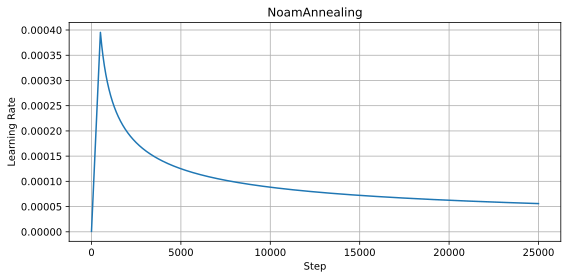

In [45]:
%%capture --no-stdout --no-display

scheduler = NoamAnnealing(
    torch.optim.Adam(model.parameters(), lr=0.2),
    d_model=512, warmup_steps=500, min_lr=1e-5
)

learning_rates = []
for _ in range(25_000):
    scheduler.step()
    learning_rates.append(scheduler.get_last_lr()[0])
    
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(learning_rates)
ax.grid(True)
ax.set_xlabel('Step')
ax.set_ylabel('Learning Rate')
ax.set_title('NoamAnnealing')

fig.tight_layout()
plt.show()

# Training Loop

In [62]:
def evaluate(model, device, epoch, data_loader, criterion) -> float:
    model.eval()
    loss = 0.0
    n_objects = 0
    
    with torch.no_grad():
        for batch in (pbar := tqdm(data_loader)):
            X, y = batch[0].float().to(device), batch[1].float().to(device)
            output = model(X).squeeze()
            loss += loss_function(output, y).item() 
            n_objects += len(X)
            pbar.set_description(f"Evaluate | Epoch {epoch} | Mean Loss {round(total_loss / n_objects, 3)}")

    return loss / n_objects

In [63]:
def train(model, device, train_loader, val_loader, n_epoch, optimizer, scheduler, 
          criterion, writer=None, max_norm=None, track_gradient=False, initial_epoch=1):
    model.to(device)
    
    for epoch in range(initial_epoch, n_epoch + initial_epoch):
        model.train()
        n_objects = 0
        total_loss = 0.0
        for batch in (pbar := tqdm(train_loader)):
            X, y = batch[0].float().to(device), batch[1].float().to(device)
            n_objects += len(X)
            
            optimizer.zero_grad()
            output = model(X).squeeze()
            loss = criterion(output, y)
            loss.backward()
            
            if max_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)
                
            if track_gradient and (writer is not None):
                norm = 0
                for p in model.parameters():
                    norm += (p.grad.data.detach().norm(2) ** 2).item()
                norm = norm ** 0.5
                writer.add_scalar('gradient_norm', norm, global_step)

            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            pbar.set_description(f"Train | Epoch {epoch} | Mean Loss {round(total_loss / n_objects, 3)}")
            
        val_loss = evaluate(model, device, epoch, val_loader)

        if writer is not None:
            writer.add_scalars('Loss', {
                'train': round(total_loss / n_objects, 3),
                'val': val_loss
            }, epoch)
            writer.flush()

# Training

In [64]:
assert torch.cuda.is_available(), "!?"
model = Conformer(
            n_channels = 63,
            n_wavelet_filters = 13,
            encoder_dim = 512,
            num_layers = 2,
            num_attention_heads = 2,
            feed_forward_expansion_factor = 2,
            conv_expansion_factor = 2,
            input_dropout_p = 0.1,
            encoded_input_dropout_p = 0.1,
            feed_forward_dropout_p = 0.1,
            attention_dropout_p = 0.1,
            conv_dropout_p = 0.1,
            conv_kernel_size = 31,
            half_step_residual = True,
            #WAVELET_KWARGS
            dt=eeg_sr,
            dj=dj,
            cuda=True
).to(device);

In [49]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
scheduler = NoamAnnealing(
    optimizer, d_model=512, 
    warmup_steps=len(train_dl) // 5, min_lr=1e-5
)
writer = None
criterion = nn.MSELoss(reduction='sum')

In [50]:
n_epoch = 1
max_norm = None
track_gradient = False
initial_epoch = 1

In [51]:
train(model, device, train_dl, val_dl, n_epoch, optimizer,
      scheduler, criterion, writer=writer, max_norm=max_norm,
      track_gradient=track_gradient, initial_epoch=initial_epoch)

  0%|          | 0/5592 [00:00<?, ?it/s]


KeyboardInterrupt

